In [56]:
%load_ext autoreload
import sys
sys.path.append('../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import numpy as np

In [58]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
video_path = '/home/paulo/Vídeos/eliziane.mp4'

In [60]:
dir_path = video_path.split('.')[0]
dir_path

'/home/paulo/Vídeos/eliziane'

# Extract Video Frames

In [ ]:
cap=cv2.VideoCapture(video_path)

In [ ]:
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

In [ ]:
fps

In [ ]:
if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [ ]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Get urls

In [ ]:
from faces_clustering import get_files_folder, FeatureExtractor

In [ ]:
from tqdm import tqdm

In [ ]:
extractor = FeatureExtractor('senet50')

In [ ]:
frames_url = get_files_folder(dir_path)

In [ ]:
faces_dict = {}
for url in tqdm(frames_url):
    faces_dict[url] = extractor.get_embeddings(url)


In [ ]:
all_urls = []
all_faces = []
all_embs = []
for url in frames_url:
    embs, faces = faces_dict[url]
    for emb, face in zip(embs, faces):
        all_urls.append(url)
        all_faces.append(face)
        all_embs.append(emb)

In [ ]:
dt_sw = pd.DataFrame(all_urls, columns=['urls'])

In [ ]:
dt_sw['embeddings'] = all_embs
dt_sw['faces'] = all_faces

In [ ]:
dt_sw[['urls','embeddings']].head()

In [ ]:
dt_sw.to_pickle(f'{video_path}.pkl')

# Clustering

In [61]:
from faces_clustering import silhuoette

In [62]:
dt_sw = pd.read_pickle(f'{video_path}.pkl')
dt_sw.shape

(63, 3)

In [63]:
valid = dt_sw.embeddings.apply(lambda x: str(x) != '-')
dt_sw = dt_sw.loc[valid]

In [64]:
dt_sw.shape

(56, 3)

In [65]:
embs = [list(emb) for emb in dt_sw.embeddings.values]


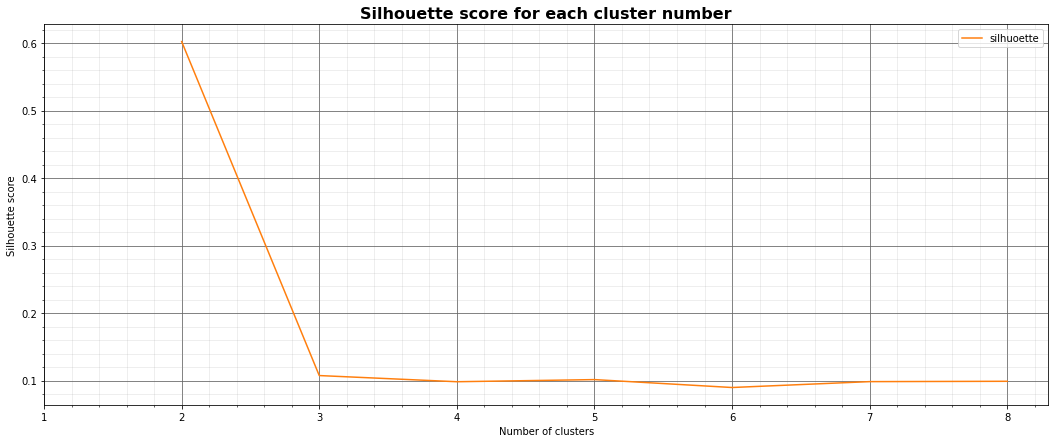

Best cluster number is 2


In [66]:
clusters_silhouette = silhuoette(embs,alg = "agglomerative")

In [67]:
dt_sw[['urls','embeddings']].head()

,urls,embeddings
0,/home/paulo/Vídeos/eliziane/frame_1350.jpg,"[0.0064639305, 0.012421935, 4.8022203, 0.00738..."
1,/home/paulo/Vídeos/eliziane/frame_1410.jpg,"[0.03624429, 0.010428948, 1.9488852, 0.0059236..."
2,/home/paulo/Vídeos/eliziane/frame_300.jpg,"[0.38004994, 0.0052547837, 0.8525081, 0.008417..."
3,/home/paulo/Vídeos/eliziane/frame_540.jpg,"[0.0256735, 0.0032128661, 4.231549, 0.00795003..."
4,/home/paulo/Vídeos/eliziane/frame_420.jpg,"[0.019566644, 0.005303797, 3.7169557, 0.010390..."


In [68]:
alg = 'agglomerative'

In [69]:
#clusterer = Clusterer(n_clusters = 2, face_embeddings = dt_sw,algs=[alg])

In [70]:
#clusters, _ = clusterer.clusterize()

In [71]:
#clusters.head()

clusters = dt_sw.copy()
clusters[f'cluster_{alg}'] = clusters_silhouette
clusters[['urls','embeddings',f"cluster_{alg}"]].head()

,urls,embeddings,cluster_agglomerative
0,/home/paulo/Vídeos/eliziane/frame_1350.jpg,"[0.0064639305, 0.012421935, 4.8022203, 0.00738...",0
1,/home/paulo/Vídeos/eliziane/frame_1410.jpg,"[0.03624429, 0.010428948, 1.9488852, 0.0059236...",0
2,/home/paulo/Vídeos/eliziane/frame_300.jpg,"[0.38004994, 0.0052547837, 0.8525081, 0.008417...",0
3,/home/paulo/Vídeos/eliziane/frame_540.jpg,"[0.0256735, 0.0032128661, 4.231549, 0.00795003...",0
4,/home/paulo/Vídeos/eliziane/frame_420.jpg,"[0.019566644, 0.005303797, 3.7169557, 0.010390...",0


In [72]:
faces_samples = clusters[[f'cluster_{alg}','faces']].sort_values(
    f'cluster_{alg}').groupby(f'cluster_{alg}').head(1).faces.values

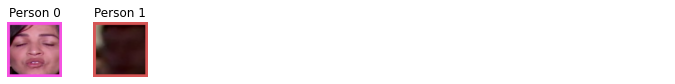

In [73]:
colors = list(np.random.random(size=(len(faces_samples),3)) * 256)
def show_people_video():
    fig, axes = plt.subplots(nrows=1, ncols=max(len(faces_samples),8), figsize=(12, 1))
    #fig.tight_layout()
    #fig.subplots_adjust(hspace=0, wspace=0)
    i = 0
    [axi.set_axis_off() for axi in axes.ravel()]
    for sample in faces_samples:
        #axes.figure(figsize=(2,3))
        image = cv2.rectangle(sample, (0,0), sample.shape[0:2], colors[i], int(sample.shape[0]/10))

        axes[i].set_title(f'Person {i}')
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_aspect('equal')
        i = i+1

show_people_video()


# Clusters by frame

In [74]:
clusters_urls = clusters[[f'cluster_{alg}','urls']]

In [75]:
frames = clusters_urls.urls.apply(lambda x: int(x.split('.')[0].split('/')[-1].split('_')[-1]))

In [76]:
clusters_frames = clusters_urls[[f'cluster_{alg}']]

In [77]:
clusters_frames['frames'] = frames

In [78]:
cluster_by_frames = clusters_frames.groupby('frames')[f'cluster_{alg}'].apply(list)

In [79]:
#cluster_by_frames = cluster_by_frames.apply(np.sort)

In [80]:
cluster_by_frames = pd.DataFrame(cluster_by_frames)

In [81]:
#adding frames without faces

dt_original = pd.read_pickle(f'{video_path}.pkl')
all_frames = set(dt_original.urls.apply(lambda x: int(x.split('.')[0].split('/')[-1].split('_')[-1])).values)

for f in all_frames:
    if f not in cluster_by_frames.index.values:
        cluster_by_frames.loc[f] = [[]]
cluster_by_frames = cluster_by_frames.sort_index()

In [82]:
cluster_by_frames.shape

(60, 1)

# Display Timeline

In [83]:
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [84]:
def draw_lines(frame, clusters):
    thumb = f'{dir_path}/frame_{frame}.jpg'
    img = cv2.imread(thumb)
    test = img[:,:,::-1].copy()
    for c in clusters:

        line_thickness = int((img.shape[0]/3)/len(faces_samples))

        test = cv2.line(test, (0,test.shape[0]-line_thickness*(c+1)), 
                 (img.shape[1]-1,test.shape[0]-line_thickness*(c+1)), colors[c], thickness=line_thickness)

    return test

100%|██████████| 60/60 [00:03<00:00, 19.77it/s]


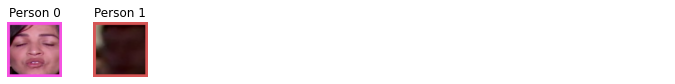

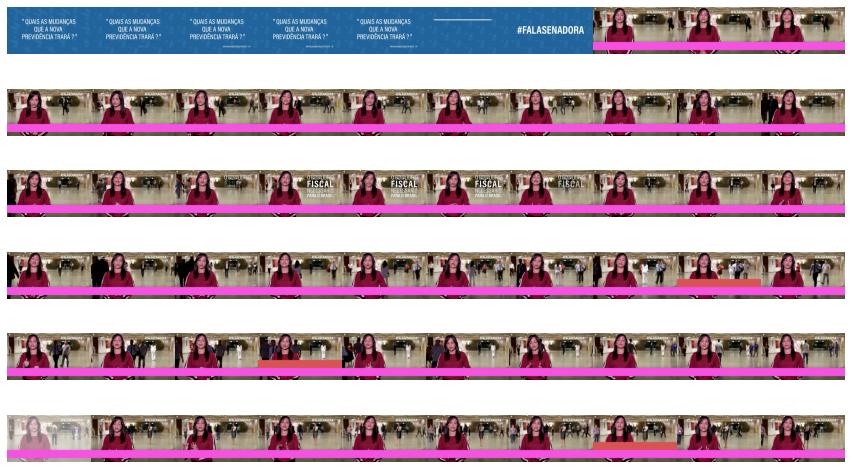

In [85]:
row_number = int(np.ceil(cluster_by_frames.shape[0]/10))

show_people_video()

plt.figure(figsize = (15,row_number*1.5))
gs1 = gridspec.GridSpec(row_number, 10)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 
i = 0
for frame in tqdm(cluster_by_frames.index.values):
    thumb = draw_lines(frame, cluster_by_frames.loc[frame][0])
    
    ax1 = plt.subplot(gs1[i])  
    plt.subplots_adjust(hspace=0, wspace=0)
    ax1.imshow(thumb)
    ax1.axis('off')
    #ax1.set_aspect('equal')
    
    i = i + 1

## Cluster Matching

In [86]:
classes_col = f'cluster_{alg}'

cluster_embeddings = pd.DataFrame(clusters['embeddings'].values.tolist(),index=clusters.index)
cluster_embeddings[classes_col] = clusters[classes_col]
centroids = cluster_embeddings.groupby([classes_col]).mean()

centroids

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
cluster_agglomerative,,,,,,,,,,,,,,,,,,,,,
0,0.140215,0.005425,2.439808,0.011707,6.554243,2.859924,0.060556,5.149936,0.861468,0.029239,...,3.290385,14.944629,0.042906,0.734695,0.092690,0.246594,0.580442,0.074211,0.012781,4.351633
1,0.015135,0.773243,0.605502,0.133865,0.425934,0.414397,0.362845,0.056501,2.298115,1.330946,...,2.427972,2.551426,0.045993,0.965622,3.364661,0.839292,0.657282,0.017505,0.020448,0.116629


In [87]:
from faces_clustering import FaceSearcher

df_embs = pd.read_pickle('../../data/clusters_train_leg55.pkl').loc['senet50']
df_embs.urls = df_embs.urls.apply(lambda x: x
                                  .replace('C:/Users/paulo/Documents/FacesProject', '/home/paulo/Documentos')
                                  .replace('\\','/'))
df_embs.head()


searcher = FaceSearcher(face_embs = df_embs, classes_col = classes_col)

In [88]:
_, results = searcher.closest_centroids(embs_query = centroids.values)

In [89]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))
def m1(x, k):
    m1 = softmax((1/x).nlargest(k)).head(1)
    return (m1.index.values[0],m1.values[0])

In [90]:
assign_cluster = lambda x: m1(x,k=4)[0] if m1(x,k=4)[1] >= 0.5 else -1

Person 0 is:


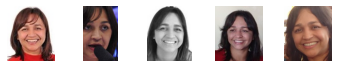

Person 1 is:
Nobody


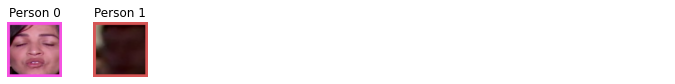

In [91]:
max_samples = 5

for i, result in enumerate(results):    
    assigned_cluster = assign_cluster(result)
    print(f"Person {i} is:")
    if assigned_cluster != -1:
        fig, axes = plt.subplots(nrows=1, ncols=max_samples, figsize=(6, 1))
        urls = df_embs.loc[df_embs.cluster_agglomerative == assigned_cluster].head(max_samples).urls
        [axi.set_axis_off() for axi in axes.ravel()]
        for j, url in enumerate(urls):
            axes[j].imshow(cv2.imread(url)[:,:,::-1])
            #axes[i].axis('off')
        #plt.title = f"Person {i}"
        
        plt.show()
    else:
        print("Nobody")
show_people_video()